# %% [markdown]
# **Disclaimer:** This notebook was created with AI assistance as part of my learning journey in scientific machine learning and Physics-Informed Neural Networks (PINNs).

Training Regular ML...
Done.
Training PINN...
Done.


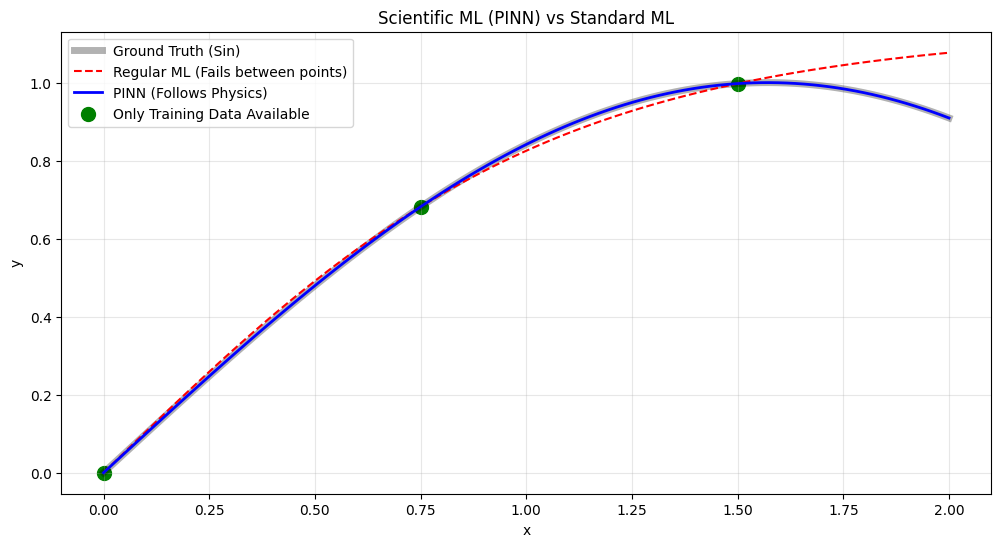

In [4]:
# %% [markdown]
# # Physics-Informed Neural Networks (PINNs) vs. Standard Neural Networks
# This notebook compares a standard MLP with a PINN by fitting a sine wave.
# The PINN uses the underlying physical law: d²y/dx² + y = 0.

# %%
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# %% [markdown]
# ## 1. Define the Neural Network
# We use the same architecture for both models to ensure a fair comparison.
# We use Tanh activation because it has continuous non-zero derivatives (required for PINNs).

# %%
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 1)
        )
    def forward(self, x):
        return self.net(x)

# %% [markdown]
# ## 2. Prepare Training Data
# We provide very little data (only 3 points) to show how Regular ML struggles 
# while SciML (PINNs) uses "physics" to fill the gaps.

# %%
# Sparse training data (Regular ML only sees these)
x_train = torch.tensor([0.0, 0.75, 1.5]).view(-1, 1).requires_grad_(True)
y_train = torch.sin(x_train)

# Physics points (Collocation points) - No labels (y) needed here!
# These are points where we tell the model: "Regardless of the label, follow the law of physics."
x_physics = torch.linspace(0, 2, 30).view(-1, 1).requires_grad_(True)

# %% [markdown]
# ## 3. Train Regular Machine Learning Model
# This model only learns from the 3 green dots.

# %%
model_regular = SimpleNet()
optimizer_reg = torch.optim.Adam(model_regular.parameters(), lr=0.01)
mse_loss = nn.MSELoss()

print("Training Regular ML...")
for i in range(2000):
    optimizer_reg.zero_grad()
    y_pred = model_regular(x_train)
    loss = mse_loss(y_pred, y_train)
    loss.backward(retain_graph=True)
    optimizer_reg.step()
print("Done.")

# %% [markdown]
# ## 4. Train PINN (Scientific ML) Model
# This model learns from the 3 dots AND the second-order differential equation.

# %%
model_pinn = SimpleNet()
optimizer_pinn = torch.optim.Adam(model_pinn.parameters(), lr=0.01)

print("Training PINN...")
for i in range(2000):
    optimizer_pinn.zero_grad()
    
    # Task 1: Fit the data (MSE Loss)
    y_pred_data = model_pinn(x_train)
    loss_data = mse_loss(y_pred_data, y_train)
    
    # Task 2: Satisfy the Physics (Residual Loss)
    # We calculate derivatives of the output with respect to the input
    y_p = model_pinn(x_physics)
    
    # dy/dx
    grads = torch.autograd.grad(y_p, x_physics, torch.ones_like(y_p), create_graph=True, retain_graph=True)[0]
    # d²y/dx²
    grads2 = torch.autograd.grad(grads, x_physics, torch.ones_like(grads), create_graph=True)[0]
    
    # The ODE for a sine wave: y'' + y = 0
    loss_physics = torch.mean((grads2 + y_p)**2)
    
    # Total Loss
    total_loss = loss_data + loss_physics
    total_loss.backward(retain_graph=True)
    optimizer_pinn.step()
print("Done.")

# %% [markdown]
# ## 5. Compare Results
# Visualizing how the physics constraint helps the model generalize between data points.

# %%
x_test = torch.linspace(0, 2, 100).view(-1, 1)
with torch.no_grad():
    y_reg = model_regular(x_test)
    y_pinn = model_pinn(x_test)
    y_true = torch.sin(x_test)

plt.figure(figsize=(12, 6))
plt.plot(x_test, y_true, label="Ground Truth (Sin)", color='black', alpha=0.3, lw=5)
plt.plot(x_test, y_reg, label="Regular ML (Fails between points)", color='red', ls='--')
plt.plot(x_test, y_pinn, label="PINN (Follows Physics)", color='blue', lw=2)
plt.scatter(x_train.detach(), y_train.detach(), color='green', s=100, label="Only Training Data Available")
plt.title("Scientific ML (PINN) vs Standard ML")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# %% [markdown]
# **How PINNs Work: Physics is Hardcoded in the Loss Function**
# 
# PINNs don't "learn" physical laws from data alone - the governing equations are explicitly programmed by the user into the physics loss term. For example, the ODE `y'' + ω²y = 0` is enforced by computing derivatives and measuring the residual:
# 
# ```python
# loss_physics = torch.mean((grads2 + omega**2 * y_p)**2)
# ```
# 
# The neural network learns to minimize this residual, finding solutions that satisfy both the data and the physics. For inverse problems, unknown parameters (like ω) become trainable, but the equation structure must be provided by domain experts.

# %% [markdown]
# ## 6. Inverse Problem Comparison: Normal ML vs PINN
# In this section, we compare solving the inverse problem (estimating ω) using:
# - **Normal ML**: Learns ω and network parameters by minimizing data loss only
# - **PINN**: Learns ω and network parameters by minimizing both data loss and physics loss
# 
# We'll use data from y = sin(2x) (true ω = 2) and see which approach recovers the correct parameter.

In [5]:
# %%
# Normal ML Inverse: Estimate ω from data only (no physics)
model_inv_ml = SimpleNet()
omega_ml = torch.nn.Parameter(torch.tensor(1.0))  # Initial guess ω=1
optimizer_inv_ml = torch.optim.Adam(list(model_inv_ml.parameters()) + [omega_ml], lr=0.01)

print("Training Normal ML Inverse...")
for i in range(3000):
    optimizer_inv_ml.zero_grad()
    
    # Only data loss - no physics constraint
    y_pred_data = model_inv_ml(x_inv_train)
    loss_data = mse_loss(y_pred_data, y_inv_train)
    
    # Note: ω is optimized but doesn't affect the loss directly without physics
    # The model can fit data without correct ω since it's flexible
    
    loss_data.backward(retain_graph=True)
    optimizer_inv_ml.step()
    
    if i % 500 == 0:
        print(f"Epoch {i}, Data Loss: {loss_data.item():.4f}, ω: {omega_ml.item():.4f}")

print(f"Final ω (Normal ML): {omega_ml.item():.4f} (True value: 2.0)")

Training Normal ML Inverse...
Epoch 0, Data Loss: 0.4893, ω: 1.0000
Epoch 500, Data Loss: 0.0000, ω: 1.0000
Epoch 1000, Data Loss: 0.0000, ω: 1.0000
Epoch 1500, Data Loss: 0.0000, ω: 1.0000
Epoch 2000, Data Loss: 0.0000, ω: 1.0000
Epoch 2500, Data Loss: 0.0000, ω: 1.0000
Final ω (Normal ML): 1.0000 (True value: 2.0)


In [6]:
# %%
# Inverse Problem: Estimate ω from data y = sin(2x)
# True ω = 2, but we'll learn it

# Generate "observed" data from sin(2x)
x_inv_train = torch.tensor([0.0, 0.5, 1.0, 1.5, 2.0]).view(-1, 1).requires_grad_(True)
y_inv_train = torch.sin(2 * x_inv_train)  # True solution with ω=2

# Physics points for enforcing ODE
x_inv_physics = torch.linspace(0, 2, 50).view(-1, 1).requires_grad_(True)

# Model and learnable parameter ω
model_inv = SimpleNet()
omega = torch.nn.Parameter(torch.tensor(1.0))  # Initial guess ω=1
optimizer_inv = torch.optim.Adam(list(model_inv.parameters()) + [omega], lr=0.01)

print("Training Inverse PINN...")
for i in range(3000):
    optimizer_inv.zero_grad()
    
    # Data loss
    y_pred_data = model_inv(x_inv_train)
    loss_data = mse_loss(y_pred_data, y_inv_train)
    
    # Physics loss with learnable ω
    y_p = model_inv(x_inv_physics)
    grads = torch.autograd.grad(y_p, x_inv_physics, torch.ones_like(y_p), create_graph=True, retain_graph=True)[0]
    grads2 = torch.autograd.grad(grads, x_inv_physics, torch.ones_like(grads), create_graph=True)[0]
    
    # ODE: y'' + ω²y = 0
    loss_physics = torch.mean((grads2 + omega**2 * y_p)**2)
    
    total_loss = loss_data + loss_physics
    total_loss.backward(retain_graph=True)
    optimizer_inv.step()
    
    if i % 500 == 0:
        print(f"Epoch {i}, Loss: {total_loss.item():.4f}, ω: {omega.item():.4f}")

print(f"Final ω: {omega.item():.4f} (True value: 2.0)")

Training Inverse PINN...
Epoch 0, Loss: 0.5398, ω: 0.9900
Epoch 500, Loss: 0.0011, ω: 1.9649
Epoch 1000, Loss: 0.0038, ω: 1.9931
Epoch 1500, Loss: 0.0001, ω: 1.9945
Epoch 2000, Loss: 0.0006, ω: 1.9968
Epoch 2500, Loss: 0.0019, ω: 1.9929
Final ω: 1.9968 (True value: 2.0)


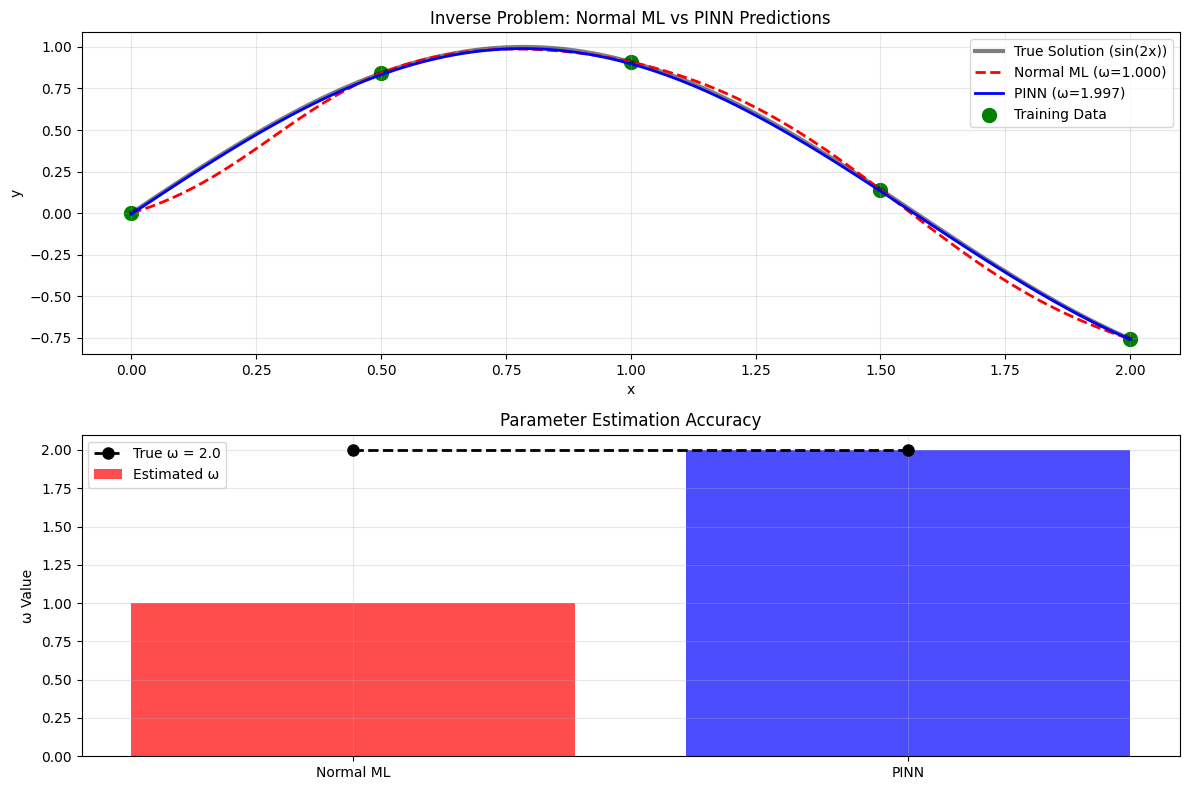

Normal ML estimated ω: 1.0000
PINN estimated ω: 1.9968
True ω: 2.0


In [7]:
# %%
# Visualize inverse problem results: Normal ML vs PINN
x_inv_test = torch.linspace(0, 2, 100).view(-1, 1)
with torch.no_grad():
    y_inv_pred_ml = model_inv_ml(x_inv_test)
    y_inv_pred_pinn = model_inv(x_inv_test)
    y_inv_true = torch.sin(2 * x_inv_test)  # True solution

plt.figure(figsize=(12, 8))

# Subplot 1: Predictions
plt.subplot(2, 1, 1)
plt.plot(x_inv_test, y_inv_true, label="True Solution (sin(2x))", color='black', alpha=0.5, lw=3)
plt.plot(x_inv_test, y_inv_pred_ml, label=f"Normal ML (ω={omega_ml.item():.3f})", color='red', ls='--', lw=2)
plt.plot(x_inv_test, y_inv_pred_pinn, label=f"PINN (ω={omega.item():.3f})", color='blue', lw=2)
plt.scatter(x_inv_train.detach(), y_inv_train.detach(), color='green', s=100, label="Training Data")
plt.title("Inverse Problem: Normal ML vs PINN Predictions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Parameter estimation
plt.subplot(2, 1, 2)
methods = ['Normal ML', 'PINN']
estimated_omega = [omega_ml.item(), omega.item()]
true_omega = [2.0, 2.0]
x_pos = range(len(methods))

plt.bar(x_pos, estimated_omega, color=['red', 'blue'], alpha=0.7, label='Estimated ω')
plt.plot(x_pos, true_omega, 'k--', marker='o', markersize=8, linewidth=2, label='True ω = 2.0')
plt.xticks(x_pos, methods)
plt.ylabel('ω Value')
plt.title('Parameter Estimation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Normal ML estimated ω: {omega_ml.item():.4f}")
print(f"PINN estimated ω: {omega.item():.4f}")
print(f"True ω: 2.0")